In [1]:
# Parameters
run = "04_model"
base_folder = "manager"
order = ["node", "node+edge", "node+rnn", "node+edge+rnn"]
pairs = [
    ["node", "node+edge"],
    ["node", "node+rnn"],
    ["node+edge", "node+rnn"],
    ["node+rnn", "node+edge+rnn"],
]
output_dir = "notebooks/evalutation/rl_models/04_model"
basedir = "."


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


folder = os.path.join(basedir, 'data', base_folder, run)
train_folder = os.path.join(folder, 'metrics')
model_folder = os.path.join(folder, 'model')

if "output_dir" in locals():
    plot_folder = output_dir
else:
    plot_folder = os.path.join(basedir, 'plots', base_folder, run)

make_dir(plot_folder)

In [3]:
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id', 'run']

labels = [c for c in df.columns if c not in non_labels]

['update_step', 'metric', 'architecture']


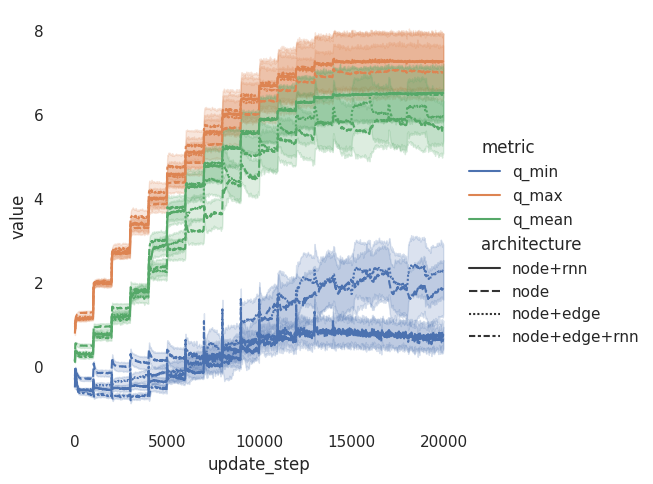

<Figure size 640x480 with 0 Axes>

In [5]:
selection = {'sampling': 'greedy'}

focus = ['update_step', 'metric', *labels]

print(focus)

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line')


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))
plt.show()
plt.clf()

['update_step', 'architecture', 'run']


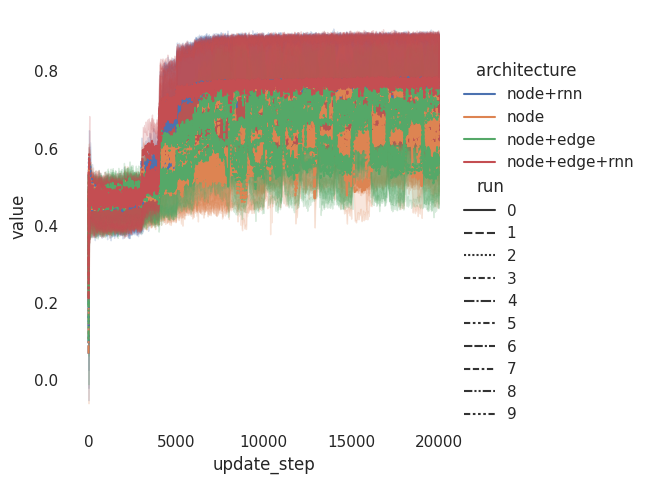

In [6]:
focus = ['update_step', labels[0], 'run', *labels[1:]]

print(focus)

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line')


fg.savefig(os.path.join(plot_folder, 'rewards.jpg'))
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

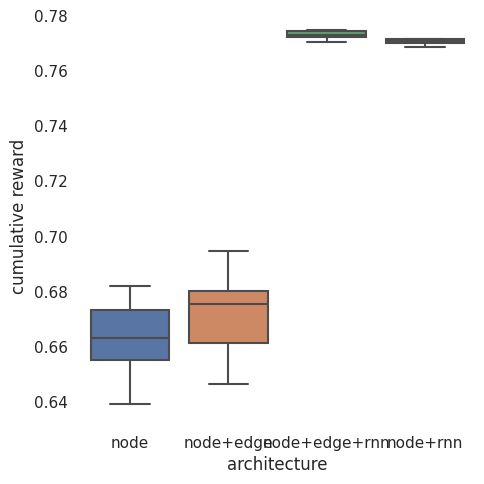

In [7]:
focus = labels

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['next_reward'])
dfs = dfs[w]

w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels + ['run'])['value'].mean().reset_index()

fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cumulative reward')
fg.savefig(os.path.join(plot_folder, 'cum_reward.jpg'))
plt.show()
plt.clf()

['node' 'node+edge' 'node+edge+rnn' 'node+rnn']


node vs. node+edge: Mann-Whitney-Wilcoxon test two-sided, P_val:2.730e-01 U_stat=3.500e+01


node+edge vs. node+rnn: Mann-Whitney-Wilcoxon test two-sided, P_val:1.827e-04 U_stat=0.000e+00
node+rnn vs. node+edge+rnn: Mann-Whitney-Wilcoxon test two-sided, P_val:1.315e-03 U_stat=7.000e+00


node vs. node+rnn: Mann-Whitney-Wilcoxon test two-sided, P_val:1.827e-04 U_stat=0.000e+00


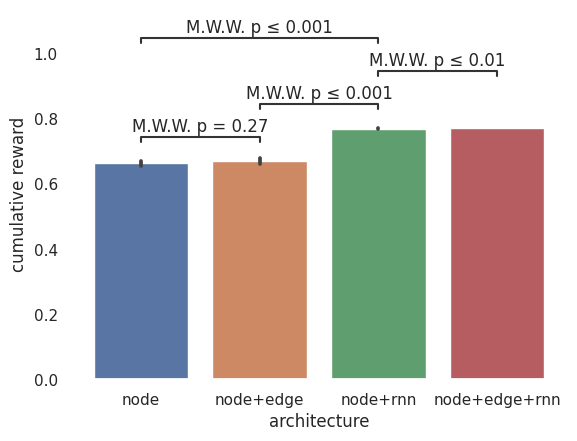

In [8]:
if (len(labels) == 1) and (pairs is not None) and (order is not None):
    from statannotations.Annotator import Annotator

    focus = labels

    w = pd.concat(
        (df[k] == v
        for k,v in selection.items() if (k not in focus) and (k in df.columns)
        ), axis=1
    ).all(1)
    dfs = df[w].reset_index(drop=True).copy()

    w = dfs['metric'].isin(['next_reward'])
    dfs = dfs[w]

    w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
    dfs = dfs[w_max].copy()

    dfs = dfs.groupby(focus + ['run'])['value'].mean().reset_index()

    dfs[focus[0]] = dfs[focus[0]].astype(str)

    print(dfs[focus[0]].unique())

    ax = sns.barplot(
        data=dfs, 
        order=order,
        y='value',
        x=focus[0],
    )

    annotator = Annotator(ax, pairs, data=dfs, x=focus[0], y='value', order=order)
    annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside')
    annotator.apply_and_annotate()
    
    ax.set(ylabel='cumulative reward')

    plt.savefig(os.path.join(plot_folder, 'model_comparision.jpg'))
    plt.show()
    plt.clf()